# NBA MVP Prediction Modeling

The 2022-2023 NBA season witnessed a highly contested MVP race that captivated fans and analysts alike. Nikola Jokic, Joel Embiid, and Giannis Antetokounmpo were at the heart of the competition, all with a captivating narrative and compelling case to make. In what was easily the most heated MVP debate since 2017, topics like racial bias, voter fatigue and the historical context of the MVP award were all brought into question. 

In the face of such a highly contested race, I seeked an objective, data-driven approach to determining the MVP. Utilizing machine learning and statistical modeling, I set out to create a prediction model that leverages historical voter data to establish a consistent rubric on evaluating the Most Valuable Player

In [1]:
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
from datetime import date
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import xgboost as xgb
from functools import partial

from nba_mvp_predictor_helper_functions import *

notebook_path = os.path.abspath("")
os.chdir(notebook_path)

pd.options.mode.chained_assignment = None  # default='warn'

## Utilizing Past MVP Voting Data

While voter behavior in the past has never been consistent, it does offer us insight into what voters value. I started by using MVP results data from the past decade 2013 - 2022 (scraped from basketball-reference.com - see data scraper for more information). 

I decided that the output I wanted to predict was Vote Share, which is the % of Points a player received out of the total maximum points available. I liked this metric over the actual place a player a came in b/c it provided contextual numerical distance and was already scaled between 0 and 1. Additionally, I decided to filter for only the top 5 vote getters from each season as my training set.

In [2]:
mvp_df = pd.read_csv('Data/mvp_results_2013_2022.csv')
mvp_df = (mvp_df.groupby('Season').apply(lambda x: x.nlargest(5, 'Pts Won')).reset_index(drop=True))
mvp_df.head()

/var/folders/g9/lxmtwlzn7rb5ds2ctlg85t480000gn/T/ipykernel_50186/3743903361.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  mvp_df = (mvp_df.groupby('Season').apply(lambda x: x.nlargest(5, 'Pts Won')).reset_index(drop=True))


,Player,Age,Season,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,LeBron James,28,2013,MIA,120.0,1207.0,1210.0,0.998,76.0,37.9,26.8,8.0,7.3,1.7,0.9,0.565,0.406,0.753,19.3,0.322
1,Carmelo Anthony,28,2013,NYK,1.0,475.0,1210.0,0.393,67.0,37.0,28.7,6.9,2.6,0.8,0.5,0.449,0.379,0.830,9.5,0.184
2,Kevin Durant,25,2014,OKC,119.0,1232.0,1250.0,0.986,81.0,38.5,32.0,7.4,5.5,1.3,0.7,0.503,0.391,0.873,19.2,0.295
3,LeBron James,29,2014,MIA,6.0,891.0,1250.0,0.713,77.0,37.7,27.1,6.9,6.3,1.6,0.3,0.567,0.379,0.750,15.9,0.264
4,Stephen Curry,26,2015,GSW,100.0,1198.0,1300.0,0.922,80.0,32.7,23.8,4.3,7.7,2.0,0.2,0.487,0.443,0.914,15.7,0.288


## Feature Selection & Engineering

Next I needed to select for the features that the model would use. They are categorized as follows:
- Scaled Counting Statistics: I used a min-max scaler on the traditional countings stats to ensures that all features have a similar influence on the model and prevents features with larger values from dominating the model. I also seperated the min-max scaling to be done per season.
    - Points, Assists, Rebounds, Turnovers and Makes and Percentages for each type of shot (2P, 3P, and FT)
- Availability Stats as Percentage of Total: similar to the scaled counting stats, I took these as the % of total (82 games and 48 minutes)
    - Games, and Minutes Played
- Advanced Statistics: contains most of the frequently used advanced statistics. decided to split offensive and defensive stats b/c these defensive metrics were too biased towards big men, and adding them together would remove the model's ability to differentiate the importance of the two
    - PER, True Shooting %, Rebound, Assist and Turnover Percentage, Usage Rate, Off and Def Win Shares, and Off and Def Box Plus Minus
- Engineered Statistic: I decided to create a new statistic that captures the player's contribution to a team wins. it's similar Win Shares, but is not as dependent on efficiency
    - Win Contribution calculated as (Team Wins * Minutes Played / 48 * Games Played / 82 * Usage Rate -> then min-max scaled)

In [3]:
#Stats_Df scraped using the NBA Scraper Notebook
stats_df = pd.read_csv('Data/season_stats_13_22.csv')
stats_df = df_transform(stats_df)
#Join to MVP DataFrame
mvp_train = join_dataframes(mvp_df, stats_df)
mvp_train.head()

,Player,Age,Season,Tm,Actual_Rank,First,Share,G,3P,3P%,...,TRB%,AST%,TOV%,USG%,OWS,DWS,OBPM,DBPM,Win_Contrib,Minutes
0,LeBron James,28,2013,MIA,1.0,120.0,0.998,0.93,0.26,0.41,...,13.1,36.4,12.4,0.30,14.6,4.7,9.3,2.4,0.90,0.79
1,Carmelo Anthony,28,2013,NYK,2.0,1.0,0.393,0.82,0.43,0.38,...,10.8,14.1,9.3,0.36,7.5,2.0,6.0,-1.7,0.74,0.77
2,Kevin Durant,25,2014,OKC,1.0,119.0,0.986,0.99,0.45,0.39,...,10.8,26.7,12.2,0.33,14.8,4.4,8.8,1.4,0.94,0.80
3,LeBron James,29,2014,MIA,2.0,6.0,0.713,0.94,0.28,0.38,...,11.5,32.0,14.4,0.31,12.3,3.7,7.8,1.1,0.75,0.79
4,Stephen Curry,26,2015,GSW,1.0,100.0,0.922,0.98,0.68,0.44,...,7.0,38.6,14.3,0.29,11.5,4.1,8.2,1.7,0.79,0.68


/var/folders/g9/lxmtwlzn7rb5ds2ctlg85t480000gn/T/ipykernel_50186/3787025150.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = mvp_train.corr()


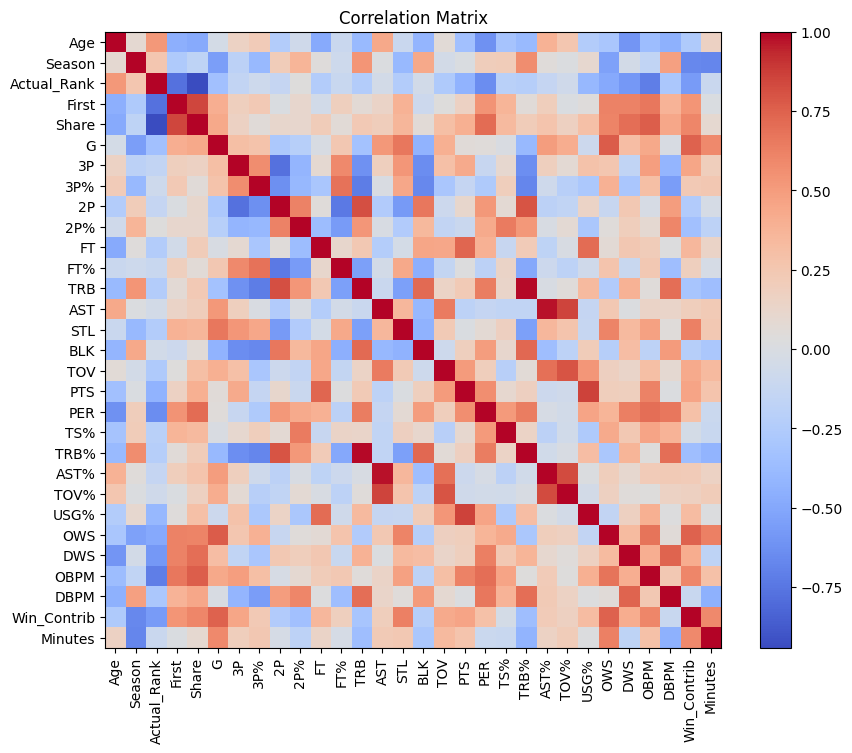

In [4]:
#Generate Correlation Matrix
corr_matrix = mvp_train.corr()

# Plot correlation matrix
plt.figure(figsize=(10,8))
plt.title("Correlation Matrix")
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()

## Model Training and Evaluation

As I started to train the model, I realized some of standard functions traditionally used in Machine Learning modeling problems will not work for this particular problem. I decided to write custom functions for the following:

1. train-test-split: instead of randomly splitting rows into training and test sets, I decided to randomly split entire seasons of data. because there's limited training data compared to traditional ML problems, it was important that each set had the proportion of MVP winners
2. weighted error: while the model was predicting "share", the question we're most interested in is obviously who won the MVP, which is the rank of the actual share. a standard root mean square error isn't as helpful here so I used a custom error formula that weighs the difference in the predicted rank vs. actual rank such that
    - If the actual rank is 1 (aka the real MVP), the absolute difference between the predicted rank will be multiplied by 5
    - If the actual rank is 2 (runner-up), the abs. difference will be multiplied by a weight of 3
    - All other actual rankis, the weights will be 1

In [5]:
X, y = xy_split(mvp_train)

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, train, test = season_train_test_split(mvp_train, 4, random_state = 42)

### 1. Linear Regression
Starting with a simple linear regression model, and found positive initial results where the test data had 0 Weighted error (meaning it accurately predicted all of the MVP ranks). While this is promising, it could mean the model is overfitting)

In [7]:
# create a LinearRegression model
linear_reg = LinearRegression()

# train the LR model on the training data
linear_reg.fit(X_train, y_train)

# make predictions on the test set
y_pred = linear_reg.predict(X_test)

#Evaluate the model
lr_rmse = mean_squared_error(y_test, y_pred, squared=False).round(2)
print('Linear Regression RMSE:', lr_rmse)
lr_weighted_error = weighted_error(y_test, y_pred, test)
print(f"Weighted Rank Error: {lr_weighted_error}")

Linear Regression RMSE: 0.25
Weighted Rank Error: 0.0


### 2. Ridge Regression
Next I wanted to try a Ridge Regression model that would regularize the colinearity of the feature variables, which is obviously a major issue with a lot of these advanced metrics

In [8]:
# Initialize the model
ridge = Ridge(alpha=0.5)

# Fit the model on the training data
ridge.fit(X_train, y_train)

# Predict on the test data
y_pred = ridge.predict(X_test)

# Calculate Errors
r_rmse = mean_squared_error(y_test, y_pred, squared=False).round(2)
print('Ridge Regression RMSE:', r_rmse)
r_weightd_error = weighted_error(y_test, y_pred, test)
print(f"Weighted Rank Error: {r_weightd_error}")

Ridge Regression RMSE: 0.19
Weighted Rank Error: 0.0


### 3. XgBoost

For XGBoost, I wanted to apply more statistical rigor. I re-split the data now to include a validation set, and applied the weighted error function as a custom evaluation metric that would train the model.

In [9]:
# Add Validation Set for XgBoost (8-1-1 split)
X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test = season_train_test_split(mvp_train, 4, validation=True, random_state = 42)

In [10]:
# Prepare the data
train_data = xgb.DMatrix(X_train, label=y_train)
valid_data = xgb.DMatrix(X_valid, label=y_valid)

# Set the parameters for the XGBoost model
params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_jobs': -1,
}

#Train the data
num_rounds = 1000
watchlist = [(train_data, 'train'), (valid_data, 'valid')]

model = xgb.train(
    params,
    train_data,
    num_rounds,
    watchlist,
    early_stopping_rounds=50,
    obj=custom_obj,  # Use the custom objective function
    feval=None,  # Temporarily set feval to None
    maximize=False,
    verbose_eval=10,
)

# Now that the model is trained, pass it to the custom_eval function using functools.partial
custom_eval_with_model = partial(custom_eval, model)

# Re-run the evaluation with the custom_eval function that includes the model
train_eval = custom_eval_with_model(dtrain=train_data, ref_df=train)
valid_eval = custom_eval_with_model(dtrain=valid_data, ref_df=valid)

print("Train evaluation:", train_eval)
print("Validation evaluation:", valid_eval)

[0]	train-rmse:0.30410	valid-rmse:0.33725
[10]	train-rmse:0.13610	valid-rmse:0.16009
[20]	train-rmse:0.06457	valid-rmse:0.12204
[30]	train-rmse:0.03358	valid-rmse:0.12882
[40]	train-rmse:0.01881	valid-rmse:0.13018
[50]	train-rmse:0.01107	valid-rmse:0.12999
[60]	train-rmse:0.00664	valid-rmse:0.13001
[68]	train-rmse:0.00444	valid-rmse:0.12971
Train evaluation: ('weighted_error', 0.0)
Validation evaluation: ('weighted_error', 2.0)


/usr/local/Cellar/jupyterlab/3.4.8_1/libexec/lib/python3.11/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [11]:
test_data = xgb.DMatrix(X_test)

# Make predictions on the test set
y_pred_test = model.predict(test_data)

# Calculate Errors
xgb_rmse = mean_squared_error(y_test, y_pred_test, squared=False).round(2)
print('XGBoost RMSE:', xgb_rmse)
xgb_weightd_error = weighted_error(y_test, y_pred_test, test)
print(f"Weighted Rank Error: {xgb_weightd_error}")

XGBoost RMSE: 0.24
Weighted Rank Error: 6.0


In [12]:
#Show Results of the XGBoost model
mvp2_xgb = mvp_train.copy()
y_pred = model.predict(xgb.DMatrix(X))
mvp2_xgb['Pred_Share'] = y_pred
mvp2_xgb['Predicted_Rank'] = mvp2_xgb.groupby('Season')['Pred_Share'].rank(ascending=False, method='dense')
mvp2_xgb = mvp2_xgb[['Player', 'Season', 'Actual_Rank', 'Predicted_Rank']]
mvp2_xgb.loc[mvp2_xgb.Actual_Rank != mvp2_xgb.Predicted_Rank]

,Player,Season,Actual_Rank,Predicted_Rank
2,Kevin Durant,2014,1.0,2.0
3,LeBron James,2014,2.0,1.0
8,Russell Westbrook,2017,1.0,2.0
9,James Harden,2017,2.0,3.0
10,Kawhi Leonard,2017,3.0,1.0
24,Joel Embiid,2022,2.0,3.0
25,Giannis Antetokounmpo,2022,3.0,2.0


Despite being the most robust model, XGBoost actually had the highest Weighted Rank Error, and when we look at its predicted results from the past decade of data, it actually overturns 2 races. The 2014 race where it ranks LeBron over KD, and in 2017 where it ranks Kawhi over both Russ and Harden, which while suprising is not actually totally outlandish

## Model Evaluation

In [13]:
# Aggregate Error Metrics for each Model
error_metrics = pd.DataFrame({
    'RMSE': [lr_rmse, r_rmse, xgb_rmse],
    'Weighted Rank Error': [lr_weighted_error, r_weightd_error, xgb_weightd_error]
}, index=['Linear Regression', 'Ridge Regression', 'XGBoost'])

error_metrics

,RMSE,Weighted Rank Error
Linear Regression,0.25,0.0
Ridge Regression,0.19,0.0
XGBoost,0.24,6.0


## 2023 Prediction

In [14]:
df_23 = pd.read_csv('Data/2023_data.csv')
df_23 = df_transform(df_23)
df_23 = df_23.loc[(df_23.G > 0.5) & (df_23.Minutes > 0.5)]
non_feature_cols = df_23.iloc[:, :3].columns
X_23 = df_23.drop(columns = non_feature_cols)

In [16]:
#Linear Regression Prediction
lr_23 = df_23.copy()
lr_23['Pred_Share'] = linear_reg.predict(X_23).round(2)
#lr_23 = lr_23.loc[(lr_23.PER > 16) & (lr_23.G > .6)]
lr_23['Predicted_Rank'] = lr_23['Pred_Share'].rank(ascending=False, method='dense')
lr_23 = lr_23[['Player','Win_Contrib', 'PER', 'Pred_Share', 'Predicted_Rank']]
lr_23.sort_values(by = ['Predicted_Rank'], ascending = True).head(5)

,Player,Win_Contrib,PER,Pred_Share,Predicted_Rank
399,Nikola Jokić,0.66,31.5,0.96,1.0
252,Joel Embiid,0.90,31.4,0.43,2.0
341,Luka Dončić,0.67,28.7,0.42,3.0
220,James Harden,0.57,21.6,0.39,4.0
129,Domantas Sabonis,0.55,23.5,0.38,5.0


In [17]:
#Ridge Regression Prediction
rr_23 = df_23.copy()
rr_23['Pred_Share'] = ridge.predict(X_23).round(2)
#rr_23 = rr_23.loc[rr_23.Win_Contrib > 0]
rr_23['Predicted_Rank'] = rr_23['Pred_Share'].rank(ascending=False, method='dense')
rr_23 = rr_23[['Player','Win_Contrib', 'PER', 'Pred_Share', 'Predicted_Rank']]
rr_23.sort_values(by = ['Predicted_Rank'], ascending = True).head(5)

,Player,Win_Contrib,PER,Pred_Share,Predicted_Rank
399,Nikola Jokić,0.66,31.5,0.93,1.0
252,Joel Embiid,0.90,31.4,0.63,2.0
341,Luka Dončić,0.67,28.7,0.62,3.0
166,Giannis Antetokounmpo,0.90,29.0,0.53,4.0
238,Jayson Tatum,1.00,23.7,0.46,5.0


In [18]:
#xGboost Prediction
xgb_23 = df_23.copy()
xgb_23['Pred_Share'] = model.predict(xgb.DMatrix(X_23)).round(2)
xgb_23['Predicted_Rank'] = xgb_23['Pred_Share'].rank(ascending=False, method='dense')
xgb_23 = xgb_23[['Player','Win_Contrib', 'PER', 'Pred_Share','Predicted_Rank']]
xgb_23.sort_values(by = ['Predicted_Rank'], ascending = True).head()

,Player,Win_Contrib,PER,Pred_Share,Predicted_Rank
399,Nikola Jokić,0.66,31.5,0.93,1.0
166,Giannis Antetokounmpo,0.90,29.0,0.85,2.0
252,Joel Embiid,0.90,31.4,0.77,3.0
22,Anthony Davis,0.46,27.8,0.72,4.0
235,Jaylen Brown,0.84,19.1,0.70,5.0


# Conclusion

All 3 models predicted Nikola Jokic as the MVP despite him being not the Vegas favorite. I think this speaks to the analytical marvel of Jokic's season, as well as the model's inability to account for narrative and voter fatigue.

Despite the limitations of these models, I found this exercise to be a refreshing look at how much can be evaluated by purely looking at the numbers. 